In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

COLORMAP = "Wistia"

<font size=6>**Bayesball: updating beliefs**</font>

The Bayes rule introduces the prior using just math! This is intuitively interpreted as the necessecity to think about any prior beliefs before making any assessment. And it's not something we do not all think in everyday life! Let's play a game!

# 1. Hitting a table with a ball

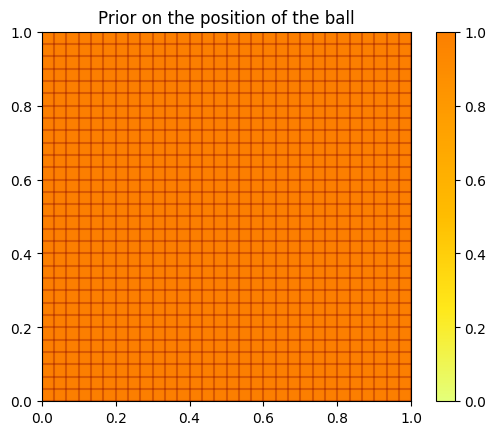

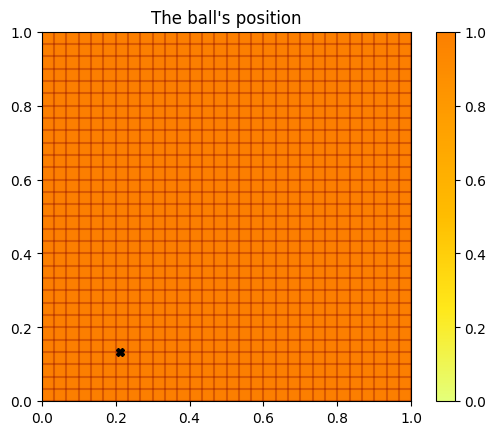

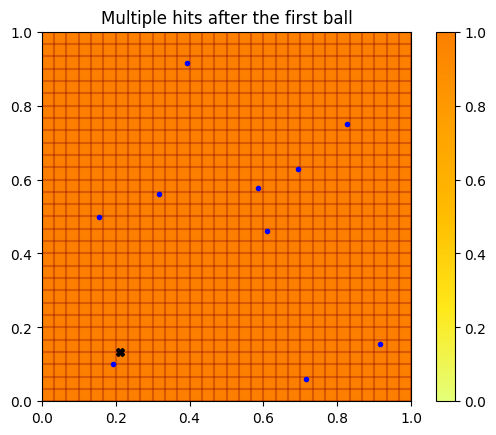

In [2]:
%matplotlib inline

table_resolution = 30
example_prior = np.ones((table_resolution, table_resolution))

def show_table(probability, target=None, hits=None, title=None, showfig=True):
    plt.figure()
    plt.title(title)
    plt.imshow(probability, cmap=COLORMAP, origin="lower", extent=(0, 1, 0, 1), vmin=0.0, vmax=1.0)
    for pos in np.linspace(0.0, 1.0, table_resolution+1):
        plt.axvline(pos, color="maroon", alpha=0.3)
        plt.axhline(pos, color="maroon", alpha=0.3)
    if target is not None:
        plt.plot(*target, marker="X", color="k")
    if hits is not None:
        hits_x, hits_y = zip(*hits)
        plt.plot(hits_x, hits_y, "b.")
    plt.colorbar()
    if showfig:
        plt.show()
    
def throw(size=1):
    return np.squeeze(np.random.rand(size, 2))


show_table(probability=example_prior, title="Prior on the position of the ball")

example_target = throw()
show_table(probability=example_prior, target=example_target, title="The ball's position")

example_hits = throw(size=10)
show_table(probability=example_prior, target=example_target, hits=example_hits, title="Multiple hits after the first ball")

# 2. A "practical" likelihood on the target's position from verbal descriptions

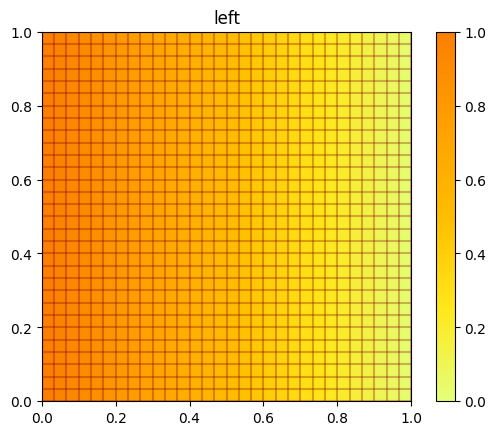

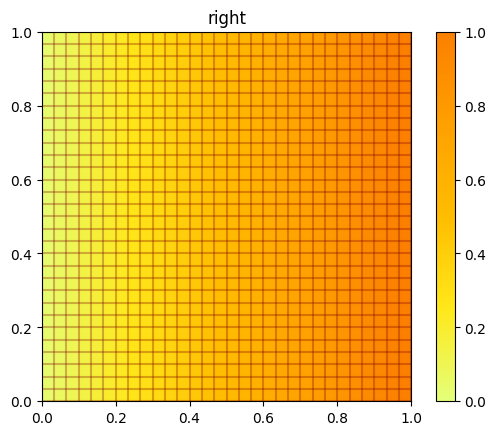

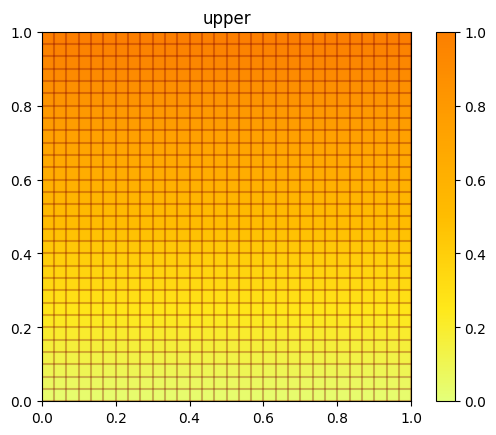

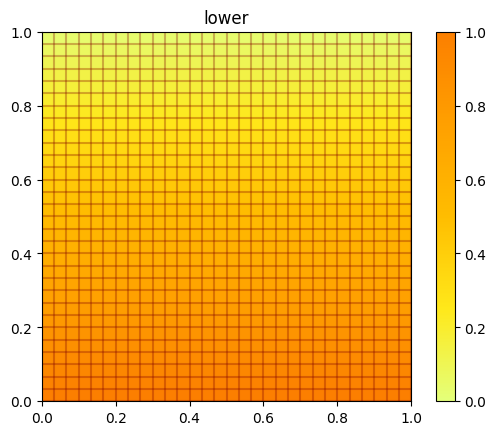

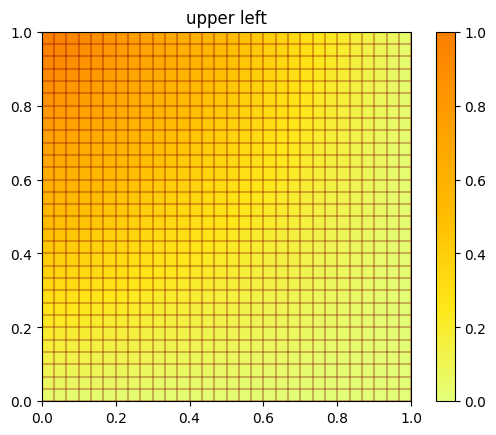

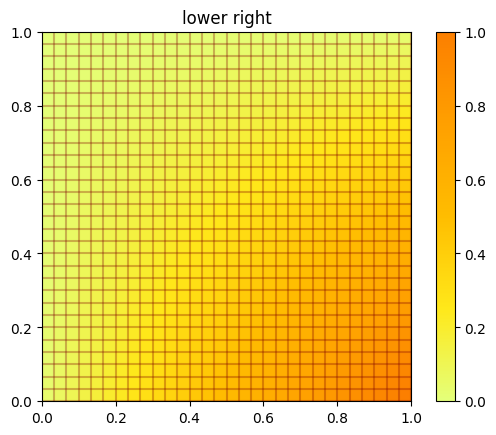

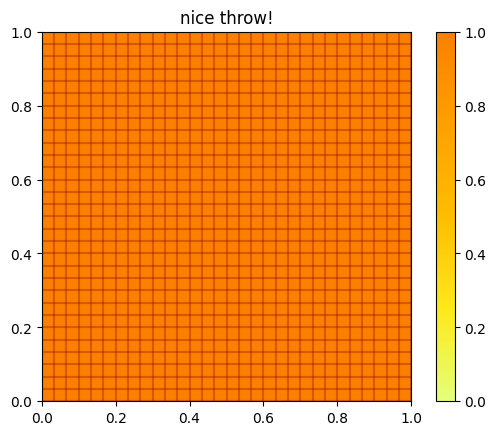

In [3]:
%matplotlib inline

def seems_like(response):
    """Compute the likelihood of the target's position based on verbal input `response`."""
    like = np.ones((table_resolution, table_resolution))   # no information = uniform likelihood
    if "right" in response:
        for col in range(table_resolution):                # the higher the column index...
            like[:, col] *= (col+1) / table_resolution     # ...the higher likelihood!
    if "left" in response:
        like *= np.fliplr(seems_like("right"))             # because left is the mirror of the right!
    if "upper" in response:
        like *= seems_like("right").T                      # transpose the right and you get the upper!
    if "lower" in response:
        like *= seems_like("left").T                       # transpose the left and you get the lower!
    return like

example_responses = ["left", "right", "upper", "lower", "upper left", "lower right", "nice throw!"]

for where in example_responses:
    show_table(seems_like(where), title=where)

# 3. Playing the game

TARGET : (0.161, 0.134)
Final estimate: (0.186, 0.123)


<IPython.core.display.Javascript object>


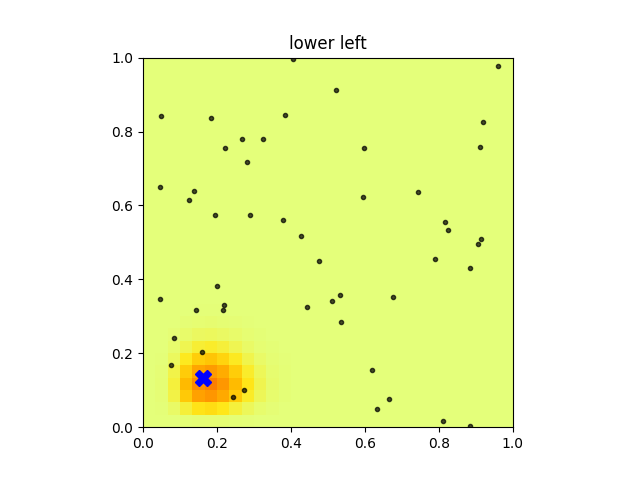

In [4]:
%matplotlib notebook

# EXPERIMENT/OUTPUT PARAMETERS

verbose = False
n_steps = 100



# A UNIFORM PRIOR
prior = np.ones((table_resolution, table_resolution))

# SOMEONE INFORMS US ABOUT THE RELATIVE POSITION OF THE BALL AND THE TARGET
def response(position, target):
    x_pos, y_pos = position
    x_tar, y_tar = target
    reply = "upper " if y_pos <= y_tar else "lower "
    reply += "right" if x_pos <= x_tar else "left"
    return reply

# THROW THE FIRST BALL
target = throw()
print("TARGET : ({:.3f}, {:.3f})".format(*target))


# LET'S PLAY THE GAME ... and yes, store all information for plotting!
hits = []
likelihoods = [prior]
titles = ["Prior"]
for i in range(n_steps):
    hit = throw()                                       # throw a bell
    reply = response(hit, target)                       # listen to the instruction
    likelihood = likelihoods[-1] * seems_like(reply)    # inform your belief
    
    # normalize and store the likelihood to avoid numerical precision issues
    likelihood /= np.max(likelihood)
    likelihoods.append(likelihood)
    hits.append(hit)
    titles.append(reply)

# CALCULATE THE FINAL ESTIMATE ON THE TARGET'S POSITION FROM THE POSTERIOR
x_estimate = np.sum(likelihood * np.linspace(0, 1, table_resolution)) / np.sum(likelihood)
y_estimate = np.sum(likelihood.T * np.linspace(0, 1, table_resolution)) / np.sum(likelihood)
print(f"Final estimate: ({x_estimate:.3f}, {y_estimate:.3f})")

# PLOT THE EXPERIMENT OUTCOMES!
fig, ax = plt.subplots(1, 1)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

def animate(step):
    ax.clear()
    hits_x, hits_y = zip(*hits[:step+1])
    plt.imshow(likelihoods[step], cmap=COLORMAP, origin="lower", extent=(0, 1, 0, 1), vmin=0.0, vmax=1.0)
    plt.plot(hits_x, hits_y, "k.", alpha=0.7)
    plt.plot(*target, marker="X", markersize=12, color="b")
    plt.title(titles[step])
    

ani = animation.FuncAnimation(fig, func=animate, frames=n_steps, interval=20, repeat=True, blit=False)
plt.show()